In [1]:
from utils.plotting import plot_behavior
from utils.sequences import add_task_identity
from utils.analysis import minimize_speed, find_attractors
from utils.rnn import MultitaskRNN, get_model, run_model, get_all_hiddens


import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Network behavior

In [22]:
task_names = ['DelayGo', 'DelayAnti']
num_hidden = 40
alpha = 0.1
activation = torch.tanh

In [ ]:

# Retrieve the model and task information
rnn, tasks = get_model(task_names, num_hidden, alpha, activation)

# Iterate over each task
for task_index in range(len(tasks)):
    task_name = tasks[task_index].__class__.__name__
    inputs, outputs, output_pred, _ = run_model(rnn, tasks, task_index)
    mask = tasks[task_index].generate_mask(grace_frac = 0.2).unsqueeze(0)



In [ ]:
plot_behavior(task_names, num_hidden, alpha, activation)

# Fixed Points

In [53]:
rnn, tasks = get_model(task_names, num_hidden, alpha, activation)

all_hiddens = get_all_hiddens(rnn, tasks)

period = "go"
stimulus = 1
task_idx = 0

input = add_task_identity(tasks[task_idx].get_input(period, stimulus), task_idx, len(tasks))

inputs = input.unsqueeze(0)  # Add a new dimension at the beginning
inputs = inputs.expand(all_hiddens.size(0), -1)  # Expand the inputs along the batch dimension

In [8]:
fps = []
for hidden in all_hiddens:
    hidden = hidden.unsqueeze(0)  # Add a new dimension at the beginning
    fp = minimize_speed(rnn, input, hidden, 0.01,  10000, 0.01)
    fps.append(fp)

fps = torch.stack(fps)  # Convert the list of tensors to a single tensor


Speed at iteration 0: 3425.717041015625
Max speed: 0.905440628528595
Speed at iteration 1000: nan
Max speed: nan
Speed at iteration 2000: nan
Max speed: nan
Speed at iteration 3000: nan
Max speed: nan
Speed at iteration 4000: nan
Max speed: nan
Speed at iteration 5000: nan
Max speed: nan
Speed at iteration 6000: nan
Max speed: nan
Speed at iteration 7000: nan
Max speed: nan
Speed at iteration 8000: nan
Max speed: nan


KeyboardInterrupt: 

In [54]:
attractors = find_attractors(rnn, inputs, all_hiddens, 100000, 100)

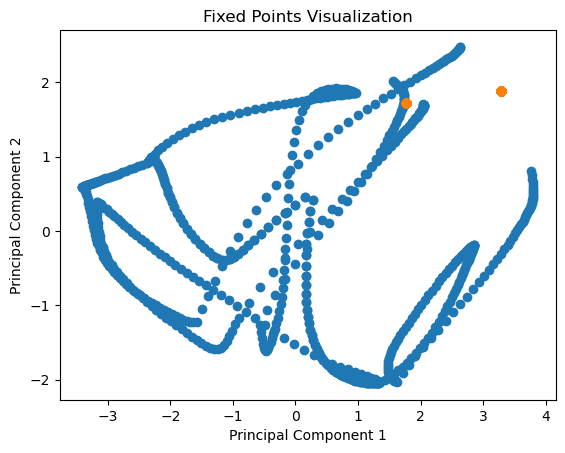

In [11]:
# Convert tensors to numpy arrays
all_hiddens_np = all_hiddens.detach().numpy()
# fps_np = fps.detach().numpy()
attractors_np = attractors.detach().numpy()

# Fit PCA on all_hiddens
pca = PCA(n_components=2)
pca.fit(all_hiddens_np)

# Transform fps using the fitted PCA model
# fps_transformed = pca.transform(fps_np)
attractors_transformed = pca.transform(attractors_np)
hiddens_transformed = pca.transform(all_hiddens_np)

# Plot the transformed fps
plt.scatter(hiddens_transformed[:, 0], hiddens_transformed[:, 1])
# plt.scatter(fps_transformed[:, 0], fps_transformed[:, 1])
plt.scatter(attractors_transformed[:, 0], attractors_transformed[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Fixed Points Visualization')
plt.show()

# Experiment with a simple network